## Estimation Example



In this document we&rsquo;ll work through a simple approach to estimating
Constant Frisch Elasticity (CFE) demand systems.

There are two prerequisites; the first is the `CFEDemands` python
module.  You may have this already, but if not it  can be installed with a simple:



In [104]:
!pip install -r requirements.txt

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


The second prerequisite is a dataset including detailed information on
household expenditures and characteristics.  The structure of that
dataset is detailed in the next section.



### Data



Consider the case in which the data are saved in a google sheet; we&rsquo;ll
turn data from these into `pandas` dataframes.
There are limits on the allowable size of google sheets (5 million
cells when I last checked), so if your dataset is larger than this you&rsquo;ll need some other
mechanism to get your data into such dataframes.  Even in this latter
case you&rsquo;ll want your dataframes to have a structure that matches the
description given below.



#### Structure of the Spreadsheet



An example spreadsheet with data for Uganda can be found at
[https://docs.google.com/spreadsheets/d/1yFWlP5N7Aowaj6t2roRSFFUC50aFD-RLBGfzGtqLl0w/](https://docs.google.com/spreadsheets/d/1yFWlP5N7Aowaj6t2roRSFFUC50aFD-RLBGfzGtqLl0w/)

This spreadsheet consists of several worksheets, labeled &ldquo;RDI&rdquo;, &ldquo;FCT&rdquo;,
&ldquo;Household Characteristics&rdquo;, and a series of different years of food expenditures and prices

Most worksheets have the initial three columns labeled &ldquo;i&rdquo;, &ldquo;t&rdquo;, and
&ldquo;m&rdquo;; together these identify an observation uniquely.  The column &ldquo;i&rdquo;
should include a household id; the column &ldquo;t&rdquo; should include an
indicator for the year or period (for those of you with
cross-sectional data these will all take a common value, e.g., 2019);
the column &ldquo;m&rdquo; should be an indicator of &ldquo;market&rdquo;, which may be a
region identifier, or may take a single value (e.g., &ldquo;Uganda&rdquo;).

The triple (i,t,m) will serve as the index of some constructed
dataframes.  It is important not to have **too** many different values
for &ldquo;m&rdquo; (unless you have lots of data and RAM to play with).

Beyond the first three columns, the &ldquo;Expenditures&rdquo; worksheet for a given year should have one index (or alternatively, one column) for each category of expenditures (e.g., &ldquo;Beans&rdquo;, &ldquo;Beef&rdquo;, &ldquo;Beer&rdquo;,&#x2026;).

Beyond the first three columns, the &ldquo;Household Characteristics&rdquo; should
have columns corresponding to different elements of the vector of
observable characteristics $z$.  If the data permit, I recommend
constructing observables that match what I have in these data:
namely numbers of different children by age and sex, along with the
logarithm of total household size (&ldquo;log HSize&rdquo;).



#### From Sheet to DataFrame to Regression Object



We begin by defining a dictionary that contains the spreadsheet key.
One is provided for the Ugandan example that I wish to work
through.



In [105]:
#Uganda_Data = '1yFWlP5N7Aowaj6t2roRSFFUC50aFD-RLBGfzGtqLl0w'
Senegal_Data = '1FrCW6vIbpHx9jDfo2tBugmkUn5XoO-j5vE2Z5dLgU0E'

With the spreadsheet defined , grab it and define a couple of
dataframes. (Sheets should be shared with `students@eep153.iam.gserviceaccount.com`):



In [108]:
import pandas as pd
import numpy as np
from eep153_tools.sheets import read_sheets

# === 1. Food Expenditures ===
#x = read_sheets(Senegal_Data, sheet='Food Expenditures (2019)')
x = pd.read_csv("./Data/Food_Expenditures_T(2019).csv", header= 0, index_col=0)
x = x.set_index(['i', 't', 'm', 'j']).squeeze()

# === 2. Food Prices ===
#p = read_sheets(Senegal_Data, sheet='Food Prices (2019)').set_index(['t', 'm', 'j', 'u'])
p = pd.read_csv('./Data/Food_Prices_T(2019).csv', header= 0).set_index(['t', 'm', 'j', 'u'])
p = p.drop(columns=["Unnamed: 0", "Unnamed: 0.1"])

# Compute medians of prices for each (t, m, j, u)
p = p.groupby(['t', 'm', 'j', 'u']).median()

# Keep only Kg unit
p = p.xs('Kg', level="u").squeeze().unstack('j')

# Find intersection of goods between price data and expenditure data
common_goods = list(set(p.columns).intersection(set(x.index.get_level_values('j'))))

# Filter both datasets to those goods
p = p[common_goods].T

# === 3. Household Characteristics ===
#d = read_sheets(Senegal_Data, sheet='Household Characteristics')
d = pd.read_csv('./Data/Household_Characteristics.csv', header= 0)
d.columns.name = 'k'

# Replace blanks with zeros
d = d.replace(np.nan, 0)

# Group expenditures and clean
x = x.T.groupby(['i', 't', 'm', 'j']).sum()
x = x.replace(0, np.nan)

# Take logs of expenditures
y = np.log(x)

# Set index for household characteristics
d.set_index(['i', 't', 'm'], inplace=True)
d = d.drop(columns=["Unnamed: 0"])

This gives a dataframe of household characteristics $d$ with a simple structure.



In [109]:
d.head()

,,k,women,girls,boys,men,Males 00-03,Females 00-03,Males 04-08,Females 04-08,Males 09-13,Females 09-13,Males 14-18,Females 14-18,Males 19-30,Females 19-30,Males 31-50,Females 31-50,Males 51-99,Females 51-99,log HSize
i,t,m,,,,,,,,,,,,,,,,,,,
11011,2018,ziguinchor,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.000000
110110,2018,ziguinchor,1,1,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1.386294
110111,2018,ziguinchor,0,0,2,2,0,0,0,0,0,0,2,0,1,0,1,0,0,0,1.386294
110112,2018,ziguinchor,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0.693147
11012,2018,ziguinchor,2,4,2,2,0,0,0,1,1,1,1,2,1,1,0,1,1,0,2.302585


Also a dataframe of log expenditures $y$ with a similarly simple
structure.  Note that any expenditures of zero are dropped and
replaced with a missing value indicator.



In [110]:
y.head()

i    t     m      j                           
221  2019  dakar  Beef                            8.006368
                  Cabbage                         4.605170
                  Caramel, candy, sweets, etc.    5.703782
                  Carrot                          4.605170
                  Cassava                         4.605170
Name: Expenditure, dtype: float64

### Estimation



Let $y_{i}^j$ be log expenditures on food $j$ by household $i$ at a particular time.  We want to estimate a regression that takes the form
$$
      y^j_{i} = A^j(p) + \gamma_j'd_i + \beta_j w_i + \zeta^j_i.
$$
We have data on `y` (log expenditures) and `d` (household characteristics).  This leaves the rest of the elements for us to estimate.



#### Basic Estimation



Just one line to set up the regression:



In [111]:
from cfe import Regression

result = Regression(y=y,d=d)

And then one line to predict expenditures and estimate most of the things we need:



In [112]:
result.predicted_expenditures()

i       t     m        j                                  
221     2019  dakar    Baobab leaves (lalo)                    107.077774
                       Beef                                   3490.727220
                       Bouillon cubes (Maggi, Jumbo, etc.)      99.763717
                       Butter                                  405.592457
                       Cabbage                                 229.066960
                                                                 ...     
259812  2019  sedhiou  Sweet banana                            270.855451
                       Sweet potato                            127.259450
                       Tea                                     145.806029
                       Tomato paste                            128.557033
                       Vinegar/mustard                         144.368164
Length: 178980, dtype: float64

Now we can compare predicted log expenditures with actual:



y      yhat
i      t    m       j                                                      
221    2019 dakar   Baobab leaves (lalo)                      NaN  4.620843
                    Beef                                 8.006368  8.015458
                    Bouillon cubes (Maggi, Jumbo, etc.)       NaN  4.386137
                    Butter                                    NaN  5.472972
                    Cabbage                              4.605170  5.234584
...                                                           ...       ...
259812 2019 sedhiou Sweet banana                              NaN  5.437278
                    Sweet potato                              NaN  4.739290
                    Tea                                  4.605170  4.952530
                    Tomato paste                         4.605170  4.774056
                    Vinegar/mustard                           NaN  4.351275

[192537 rows x 2 columns]

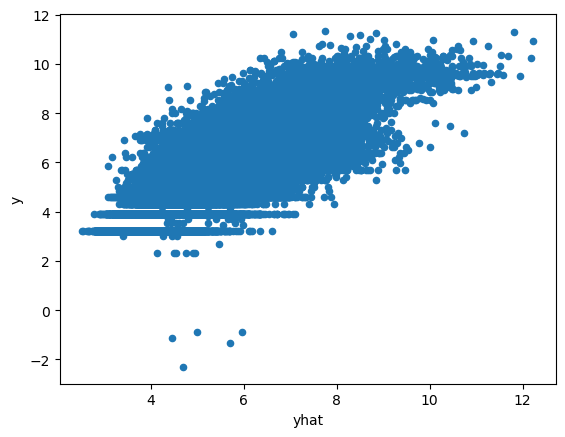

In [113]:
%matplotlib inline
df = pd.DataFrame({'y':y,'yhat':result.get_predicted_log_expenditures()})
df.plot.scatter(x='yhat',y='y')
df

That&rsquo;s all there is to estimation!  Note that we didn&rsquo;t estimate
demands for all goods&#x2014;lots of goods didn&rsquo;t have enough observations,
and were automatically dropped.



#### Parameters



##### (Relative) Income Elasticity



Some of the parameters have an interesting interpretation.  First among these are the $\beta$ coefficients, which govern how *income elastic* different goods are (higher values means more elastic).  These are also called *Frisch elasticities*.
Here we use a plot to visualize, with confidence intervals.



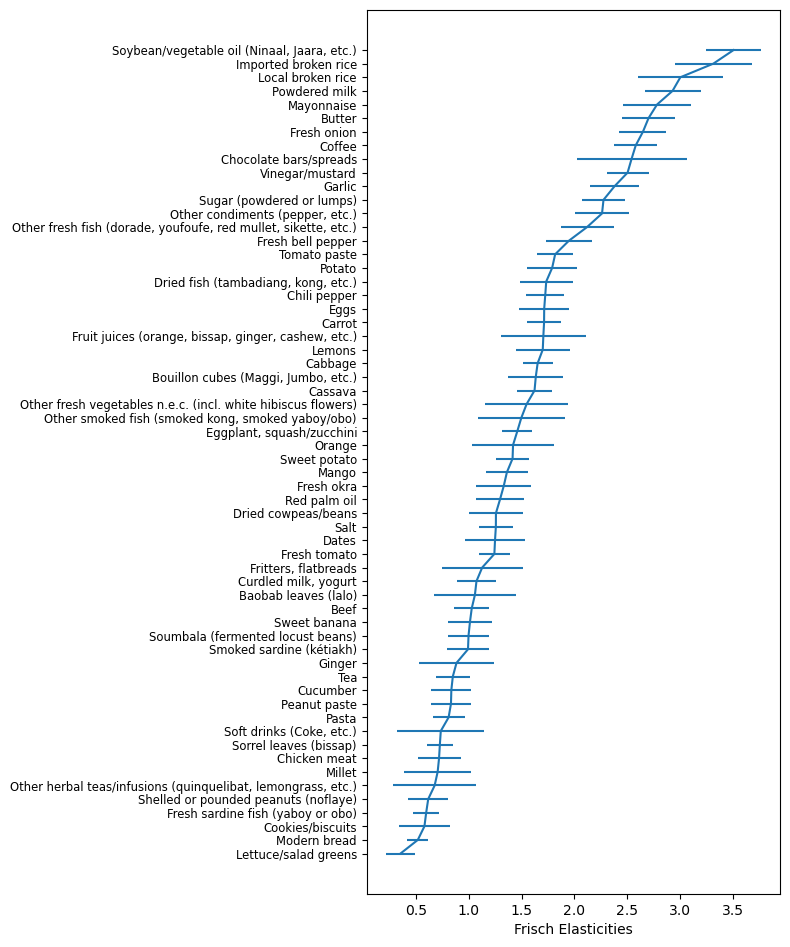

In [114]:
ax = result.graph_beta()

To just see the values of $\beta$:



In [115]:
result.get_beta()

j
Baobab leaves (lalo)                                              1.058982
Beef                                                              1.028680
Bouillon cubes (Maggi, Jumbo, etc.)                               1.634301
Butter                                                            2.700641
Cabbage                                                           1.651856
Carrot                                                            1.712786
Cassava                                                           1.622657
Chicken meat                                                      0.719736
Chili pepper                                                      1.723880
Chocolate bars/spreads                                            2.539853
Coffee                                                            2.579637
Cookies/biscuits                                                  0.581559
Cucumber                                                          0.835879
Curdled milk, yogurt   

##### Demand and Household Composition



We&rsquo;re particularly interested in the effects of household composition on demand.  These are captured by the $\gamma_j$ parameters in the regression.



In [116]:
result.get_gamma()

k,women,girls,boys,men,Males 00-03,Females 00-03,Males 04-08,Females 04-08,Males 09-13,Females 09-13,Males 14-18,Females 14-18,Males 19-30,Females 19-30,Males 31-50,Females 31-50,Males 51-99,Females 51-99,log HSize,Constant
j,,,,,,,,,,,,,,,,,,,,
Baobab leaves (lalo),0.156074,-0.057738,0.119829,0.094122,-0.086734,0.101469,-0.059864,0.154715,-0.113262,0.109330,-0.084765,0.006962,-0.100032,-0.225432,-0.136988,-0.034275,0.028048,-0.010040,-0.143442,4.369526
Beef,0.010973,0.014437,0.007809,0.024193,-0.021695,-0.053174,-0.020634,-0.016997,-0.048001,-0.023625,0.003684,-0.024899,-0.005145,0.039727,0.036322,0.070613,0.092687,0.041588,0.066584,7.779694
"Bouillon cubes (Maggi, Jumbo, etc.)",0.958984,0.927342,-1.023663,-0.980848,1.067919,-0.886174,1.066054,-0.891818,1.021297,-0.903698,1.018609,-0.941900,1.004503,-0.917992,0.983742,-0.859130,1.014270,-0.838386,-0.093550,4.210996
Butter,-1.402476,-1.662605,-0.140015,0.130126,0.083617,1.632537,0.211181,1.701425,0.080176,1.655177,0.081098,1.599504,-0.167640,1.497435,-0.141060,1.483881,-0.153448,1.404416,0.149140,5.687287
Cabbage,1.485759,1.486260,-0.352361,-0.306158,0.354626,-1.475321,0.391012,-1.452646,0.335833,-1.485062,0.353762,-1.515886,0.361270,-1.410473,0.366828,-1.380613,0.405595,-1.412818,-0.076593,4.922622
Carrot,0.618248,0.593989,0.283169,0.366963,-0.315915,-0.576286,-0.245842,-0.589391,-0.298192,-0.618458,-0.307775,-0.633711,-0.335800,-0.540435,-0.323490,-0.526013,-0.274481,-0.550336,0.008994,4.758860
Cassava,0.080532,0.093253,-0.006438,0.057661,0.026182,-0.067455,0.011889,-0.106609,0.015078,-0.062739,-0.025121,-0.118587,-0.015486,-0.042957,0.005558,-0.033929,0.036303,-0.031614,0.058022,4.743869
Chicken meat,0.077530,-0.028237,0.041276,0.043545,0.017243,0.029811,-0.002910,0.072221,-0.098405,0.057924,-0.008123,0.036860,-0.006286,-0.068724,0.027360,-0.023436,0.161462,-0.047081,-0.047947,8.235288
Chili pepper,0.694366,0.685694,0.309956,0.386236,-0.319233,-0.703148,-0.278245,-0.662633,-0.348457,-0.695711,-0.302989,-0.708394,-0.343661,-0.626054,-0.352262,-0.614427,-0.380048,-0.652160,-0.052743,4.079933


##### Welfare



Another import quantity we estimate is $w_i$.  This is a welfare measure for the household.  Here&rsquo;s a histogram:



<Axes: ylabel='Density'>

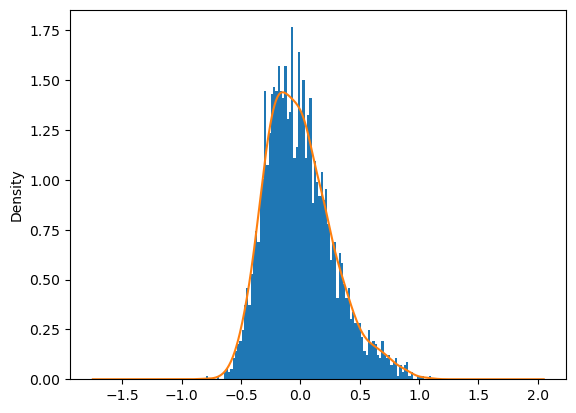

In [117]:
ax = result.get_w().plot.hist(bins=100,density=True)
result.get_w().plot.kde(ax=ax)

#### Saving Result



You can save the estimated result, using something like



In [118]:
# Save the regression result
result.to_pickle('senegal_estimates.rgsn')

You can subsequently load this using



In [119]:
import cfe
result = cfe.regression.read_pickle('senegal_estimates.rgsn')

#### Demand and Utility



Having estimated the demand system, we can examine the implied demand curves.



##### Budgets



Get food budget for all households, then find median budget:



In [130]:
import numpy as np

# Get predicted expenditures
xhat = result.predicted_expenditures()

# Total food expenditures per household (i, t, m)
xbar = xhat.groupby(['i', 't', 'm']).sum()

# Reference budget: median household's budget
xref = xbar.quantile(0.5)  # 50th percentile

##### Reference Prices



Choose reference prices.  Here we&rsquo;ll choose a particular year, and average prices across markets.  If you wanted to focus on particular market you&rsquo;d do this differently.



In [131]:
# Step 1: Average prices across markets
pbar = p.mean(axis=1)  # average over markets (axis=1)

# Step 2: Keep only goods that exist in both price data and estimated betas
estimated_goods = result.beta.index             # goods estimated by the model
available_goods = pbar.index                    # goods for which we have price data
common_goods = estimated_goods.intersection(available_goods)  # safe intersection
pbar = pbar.loc[common_goods]

# Step 3: Replace any missing values with 1 (for stability in simulations)
pbar = pbar.replace(np.nan, 1)

def my_prices(p0, j, p=pbar):
    """
    Change price of j-th good to p0, holding other prices fixed.
    
    Parameters:
    p0: new price to set
    j:  name of the good (string)
    p:  reference price vector (default: pbar)
    """
    p = p.copy()
    p.loc[j] = p0
    return p

##### Demand as a function of prices



Let&rsquo;s take a look at demand schedules for households with different budgets.



In [132]:
pbar.head()

j
Baobab leaves (lalo)    1658.333313
Beef                    2550.000000
Butter                  1600.000000
Cabbage                  500.000000
Carrot                   433.928571
dtype: float64

Available goods: ['Baobab leaves (lalo)', 'Beef', 'Bouillon cubes (Maggi, Jumbo, etc.)', 'Butter', 'Cabbage', 'Carrot', 'Cassava', 'Chicken meat', 'Chili pepper', 'Chocolate bars/spreads', 'Coffee', 'Cookies/biscuits', 'Cucumber', 'Curdled milk, yogurt', 'Dates', 'Dried cowpeas/beans', 'Dried fish (tambadiang, kong, etc.)', 'Eggplant, squash/zucchini', 'Eggs', 'Fresh bell pepper', 'Fresh okra', 'Fresh onion', 'Fresh sardine fish (yaboy or obo)', 'Fresh tomato', 'Fritters, flatbreads', 'Fruit juices (orange, bissap, ginger, cashew, etc.)', 'Garlic', 'Ginger', 'Imported broken rice', 'Lemons', 'Lettuce/salad greens', 'Local broken rice', 'Mango', 'Mayonnaise', 'Millet', 'Modern bread', 'Orange', 'Other condiments (pepper, etc.)', 'Other fresh fish (dorade, youfoufe, red mullet, sikette, etc.)', 'Other fresh vegetables n.e.c. (incl. white hibiscus flowers)', 'Other herbal teas/infusions (quinquelibat, lemongrass, etc.)', 'Other smoked fish (smoked kong, smoked yaboy/obo)', 'Pasta', 'Peanu

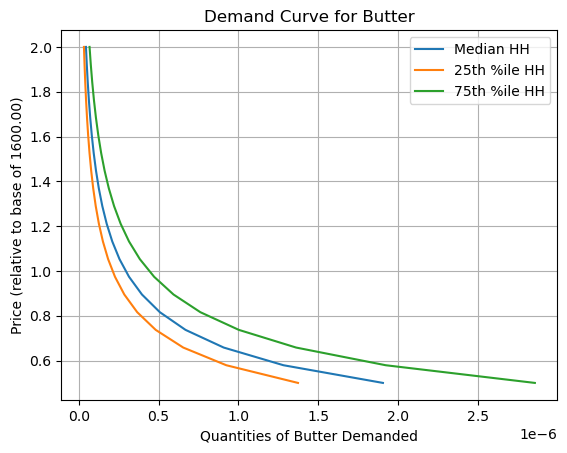

In [133]:
import matplotlib.pyplot as plt
import numpy as np

#Step 1: Get average price per good from the data
pbar_full = p.mean(axis=1)  # Average across markets

#Step 2: Reindex to match the order of goods used in the regression model
goods = result.beta.index  # This is the correct good order expected by the model
pbar = pbar_full.reindex(goods)  # Align price vector to match model order

#Step 3: Fill any missing prices with 1 (to avoid errors)
pbar = pbar.fillna(1)

#Step 4: Choose a good from the list (make sure it's in result.beta.index)
print("Available goods:", list(pbar.index))
use = 'Butter'  # Replace with another valid good if needed

#Step 5: Define a safe price-change function
def my_prices(p0, j, p=pbar):
    p = p.copy()
    p.loc[j] = p0
    return p

#Step 6: Plot demand curve
scale = np.linspace(0.5, 2, 20)

#Demand at median budget
plt.plot(
    [result.demands(xref, my_prices(pbar[use] * s, use))[use] for s in scale],
    scale,
    label='Median HH'
)

#25th percentile budget
plt.plot(
    [result.demands(xbar.quantile(0.25), my_prices(pbar[use] * s, use))[use] for s in scale],
    scale,
    label='25th %ile HH'
)

#75th percentile budget
plt.plot(
    [result.demands(xbar.quantile(0.75), my_prices(pbar[use] * s, use))[use] for s in scale],
    scale,
    label='75th %ile HH'
)

#Step 7: Final plot formatting
plt.xlabel(f"Quantities of {use} Demanded")
plt.ylabel(f"Price (relative to base of {pbar[use]:.2f})")
plt.title(f"Demand Curve for {use}")
plt.legend()
plt.grid(True)
plt.show()

##### Engel Curves



Engel curves trace out how demand changes with budget:



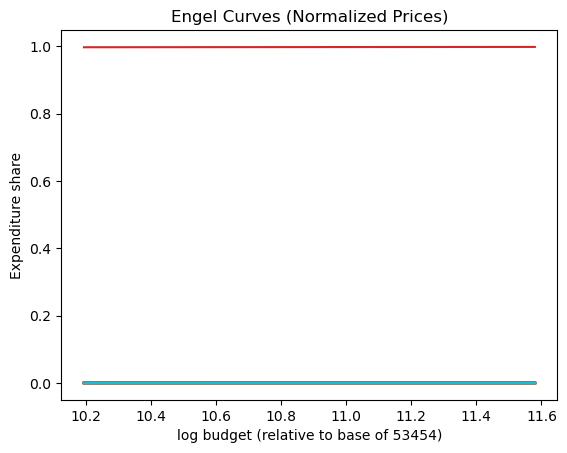

In [134]:
# Step 1: Normalize reference prices so their average is 1
pbar_normalized = pbar / pbar.mean()

# Step 2: Recalculate Engel curves with normalized pbar
fig, ax = plt.subplots()

ax.plot(
    np.log(scale * xref),
    [result.expenditures(s * xref, pbar_normalized) / (s * xref) for s in scale]
)

ax.set_xlabel(f"log budget (relative to base of {xref:.0f})")
ax.set_ylabel("Expenditure share")
ax.set_title("Engel Curves (Normalized Prices)")

plt.show()

In [135]:
# Expenditure shares at base budget
shares = result.expenditures(xref, pbar) / xref
shares.sort_values(ascending=False).head(10)

j
Soybean/vegetable oil (Ninaal, Jaara, etc.)            0.975487
Chocolate bars/spreads                                 0.010623
Mayonnaise                                             0.003768
Chicken meat                                           0.003622
Eggs                                                   0.001062
Beef                                                   0.000825
Millet                                                 0.000617
Fruit juices (orange, bissap, ginger, cashew, etc.)    0.000564
Shelled or pounded peanuts (noflaye)                   0.000548
Pasta                                                  0.000437
Name: quantities, dtype: float64

Engel Curve of Top 5 Non-Dominant Goods (exclude Huile de soja / végétale):

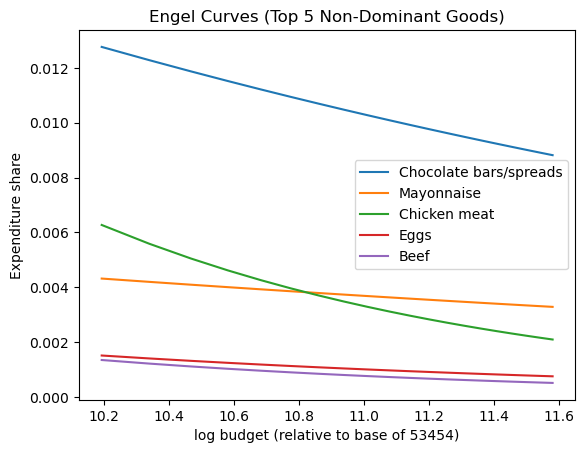

In [136]:
import numpy as np
import matplotlib.pyplot as plt
import consumerdemands._core as core

# Loosen solver tolerance to avoid convergence issues
core.default_solver_tolerance = 1e-8

# Step 1: Define scale
scale = np.linspace(0.5, 2, 20)

# Step 2: Calculate expenditure shares
shares = result.expenditures(xref, pbar) / xref
dominant_good = shares.sort_values(ascending=False).index[0]
top_goods = shares.drop(dominant_good).sort_values(ascending=False).head(5).index

# Step 3: Compute Engel curves using full price vector
fig, ax = plt.subplots()

for g in top_goods:
    share_curve = []
    for s in scale:
        try:
            demands = result.demands(s * xref, pbar)
            share = demands[g] * pbar[g] / (s * xref)
            share_curve.append(share)
        except Exception as e:
            print(f"Skipped {g} at scale {s} due to error: {e}")
            share_curve.append(np.nan)
    
    ax.plot(np.log(scale * xref), share_curve, label=g)

# Step 4: Plot formatting
ax.set_xlabel(f"log budget (relative to base of {xref:.0f})")
ax.set_ylabel("Expenditure share")
ax.set_title("Engel Curves (Top 5 Non-Dominant Goods)")
ax.legend()
plt.show()

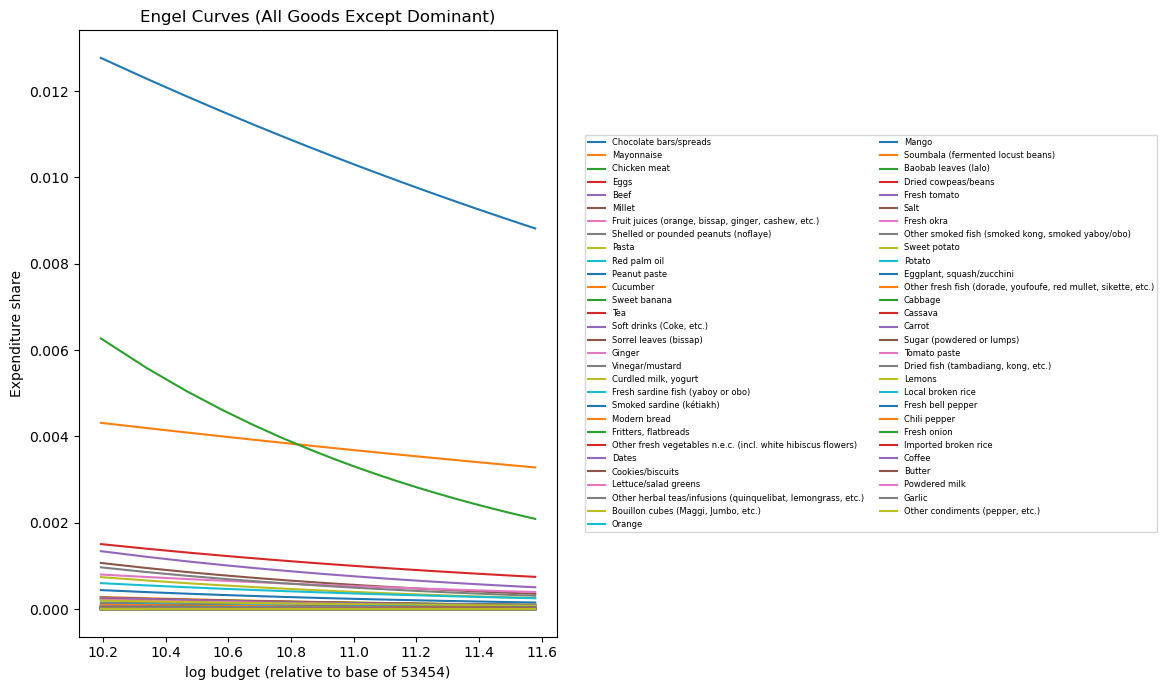

In [137]:
# Step 1: Compute expenditure shares at base budget
shares = result.expenditures(xref, pbar) / xref

# Step 2: Drop dominant good (the one with the highest share)
shares_no_dominant = shares.sort_values(ascending=False).iloc[1:]
goods_to_plot = shares_no_dominant.index

# Step 3: Budget scaling range
scale = np.linspace(0.5, 2, 20)

# Step 4: Plot Engel curves
fig, ax = plt.subplots(figsize=(12, 7))

for g in goods_to_plot:
    share_curve = [
        result.demands(s * xref, pbar)[g] * pbar[g] / (s * xref)
        for s in scale
    ]
    ax.plot(np.log(scale * xref), share_curve, label=g)

# Step 5: Labels, legend, formatting
ax.set_xlabel(f"log budget (relative to base of {xref:.0f})")
ax.set_ylabel("Expenditure share")
ax.set_title("Engel Curves (All Goods Except Dominant)")
ax.legend(fontsize=6, loc='center left', bbox_to_anchor=(1.05, 0.5), ncol=2)
plt.tight_layout()
plt.show()

##### Indirect Utility



We can also describe an indirect utility function that corresponds to these demands:



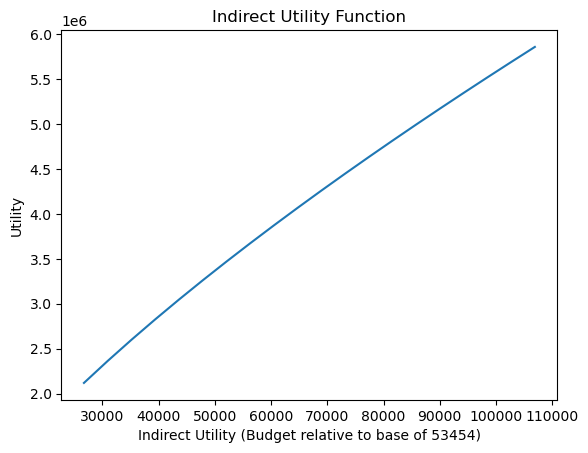

In [138]:
# Plot the indirect utility function over scaled budgets
fig, ax = plt.subplots()

# Compute utility values for different scaled budgets
utilities = [result.indirect_utility(s * xref, pbar) for s in scale]

# Plot
ax.plot(scale * xref, utilities)
ax.set_xlabel(f"Indirect Utility (Budget relative to base of {xref:.0f})")
ax.set_ylabel("Utility")
ax.set_title("Indirect Utility Function")
plt.show()

# Nutritional Analysis of Diet

In [141]:
fct = pd.read_csv("./Data/FCT.csv", index_col = 0)
fct.head()

,j,Energy,Protein,Fiber,Folate,Calcium,Carbohydrate,Iron,Niacin,Riboflavin,Thiamin,Vitamin A,Vitamin B-12,Vitamin B-6,Vitamin C,Zinc
0,Avocado,1600,20.0,70.0,810,120,85.0,6.0,17.38,1.30,0.67,70,0.0,2.57,100,6.0
1,Beans (dry),1700,98.0,60.0,500,580,325.0,30.0,7.00,1.20,3.40,0,0.0,2.15,10,8.0
2,Beans (fresh),3470,214.0,160.0,5250,1130,626.0,51.0,11.74,2.12,7.13,0,0.0,4.74,63,23.0
3,Beef,2510,182.0,0.0,60,70,0.0,19.0,31.50,1.60,0.90,0,28.9,3.80,0,37.0
4,Beef (roasted),2910,264.0,0.0,70,90,0.0,27.0,37.20,2.20,0.90,0,24.7,3.40,0,60.0


In [144]:
def get_clean_sheet(key):

    df = pd.read_csv(key)
    df.columns = [c.strip() for c in df.columns.tolist()]

    df = df.loc[:,~df.columns.duplicated(keep='first')]   

    df = df.drop([col for col in df.columns if col.startswith('Unnamed')], axis=1)

    df = df.loc[~df.index.duplicated(), :]

    return df

# Get expenditures...
expend = get_clean_sheet('./Data/Food_Expenditures_T(2019).csv')
expend

,i,t,m,j,Expenditure
0,21001,2019,ziguinchor,Garlic,25.0
1,21001,2019,ziguinchor,Butter,75.0
2,21001,2019,ziguinchor,Coffee,75.0
3,21001,2019,ziguinchor,Carrot,100.0
4,21001,2019,ziguinchor,Cabbage,50.0
...,...,...,...,...,...
93744,2989,2019,ziguinchor,Sugar (powdered or lumps),500.0
93745,2989,2019,ziguinchor,Tea,100.0
93746,2989,2019,ziguinchor,Fresh tomato,100.0
93747,2989,2019,ziguinchor,Beef,1200.0


In [149]:
def get_clean_sheet(key):

    df = pd.read_csv(key)
    df.columns = [c.strip() for c in df.columns.tolist()]

    df = df.loc[:,~df.columns.duplicated(keep='first')]   

    df = df.drop([col for col in df.columns if col.startswith('Unnamed')], axis=1)

    df = df.loc[~df.index.duplicated(), :]

    return df

# Get expenditures...
expend = get_clean_sheet('./Data/Food_Expenditures_T(2019).csv')
exp = get_clean_sheet('./Data/Food_Expenditures_T(2019).csv')

exp_wide = expend.pivot_table(
    index=["i", "t", "m"],   # The keys identifying each row
    columns="j",            # The column you want to spread out
    values="Expenditure",   # What goes in the cells
    aggfunc="sum",          # How to aggregate if you have repeats
)

# If you want 'i', 't', 'm' as columns rather than a MultiIndex, do:
expend = exp_wide.reset_index()

if 'm' not in expend.columns:
    expend['m'] = 1

expend = expend.set_index(['i','t','m'])
expend.columns.name = 'j'

expend = expend.apply(lambda x: pd.to_numeric(x,errors='coerce'))
expend = expend.replace(0,np.nan)

# Get HH characteristics...
hhc = get_clean_sheet('./Data/Household_Characteristics.csv')

if 'm' not in hhc.columns:
    hhc['m'] = 1

hhc = hhc.set_index(['i','t','m'])
hhc.columns.name = 'k'

hhc = hhc.apply(lambda x: pd.to_numeric(x,errors='coerce'))

# Get prices
p = pd.read_csv("./Data/Food_Prices_T(2019).csv")

# Make sure we have 't', 'm', 'j', 'Price' columns (drop 'Unnamed' if needed)
p = p.drop(columns=["Unnamed: 0", "Unnamed: 0.1"], errors="ignore")

# Convert to numeric if needed
p["Price"] = pd.to_numeric(p["Price"], errors="coerce")

# Pivot so each unique `j` becomes a column and
# each (t, m) is one row
p_wide = p.pivot_table(
    index=["t","m"],
    columns="j",
    values="Price",
    aggfunc="mean"  # or 'median', 'sum', etc. if duplicates exist
) #.reset_index()

p_wide.columns.name = None  # remove the pivoted index name if desired

p = p_wide #.set_index('t')

fct = get_clean_sheet('./Data/FCT.csv')

#### This bit peculiar to Niger FCT #####
#fct = fct.loc[fct.Code.str.len()==6]
#fct = fct.set_index('Code')
#fct.columns = [v.replace('\n',' ') for v in fct.columns]
########################################
fct = fct.set_index('j')
fct.columns.name = 'n'

fct = fct.apply(lambda x: pd.to_numeric(x,errors='coerce'))

################## RDI, if available (consider using US) #####################
rdi = get_clean_sheet('./Data/RDI.csv')
rdi = rdi.set_index('n')
rdi.columns.name = 'k'

In [147]:



ignore = get_clean_sheet('./Data/Food_Prices_T(2019).csv')

if 'm' not in ignore.columns:  # Supply "market" indicator if missing
    p['m'] = 1

ignore = ignore.set_index(['t','m'])
ignore.columns.name = 'j'

ignore = ignore.apply(lambda x: pd.to_numeric(x,errors='coerce'))
ignore = ignore.replace(0,np.nan)

In [ ]:

result = cfe.Regression(y=np.log(expend.stack()),d=hhc)

result.get_beta().sort_values(ascending=False) # Check sanity...

In [ ]:
#result.to_pickle('./foo.pickle')

result = cfe.regression.read_pickle('senegal_estimates.rgsn')
#result = cfe.read_pickle('foo.pickle')  # Get persistent result saved above...

xhat = result.predicted_expenditures()

# Expenditures divided by prices/kg gives quantities in kgs...
qhat = (xhat.unstack('j')/p).dropna(how='all')


# Drop missing columns
qhat = qhat.loc[:,qhat.count()>0]



In [ ]:
use = fct.index.intersection(qhat.columns)


nutrients = qhat[use]@fct.loc[use,:]
nutrients.mean()    # NB: Nutrients are for past /week/ for entire household. (Depends on dataset)
nutrients

In [ ]:
hhc.columns = hhc.columns.str.replace("Females", "F").str.replace("Males", "M")
hhc.columns = hhc.columns.str.replace("51-99", "51+")
#hhc.columns = df.columns.str.replace("M 51-99", "M 51+")
hhc

In [ ]:
hhc = hhc[rdi.columns.tolist()]

hh_rdi = hhc@rdi.T 
#z = # ppl in household , rdi => add up all ppl in household

# is senegal data per week? if so make this a recommended WEEKLY intake:
hh_rwi = hh_rdi*7

hh_rwi

In [ ]:
# Match up nutrient names
use_nutrients = nutrients.columns.intersection(hh_rwi.columns)

nutrient_ratio = (nutrients[use_nutrients]/hh_rwi[use_nutrients]).dropna()
#hh_rwi = required nutrients per week. 1 = adequate intake <1 not adequate
nutrient_ratio

In [ ]:
%matplotlib inline
nutrient_ratio['Protein'].hist(bins=200)
plt.xlim(0, 5)

In [ ]:
def filter_households(
    hhc,              # The household composition DataFrame (indexed by i,t,m)
    nutrient_ratio,   # The nutrient outcomes DataFrame (indexed by i,t,m)
    min_males=0, max_males=None,
    min_females=0, max_females=None,
    min_kids=0, max_kids=None
):
    """
    Return the rows (households) whose composition fits the given
    # of adult males, adult females, and children,
    along with their corresponding nutrient outcomes.
    Both DataFrames must be MultiIndexed by (i, t, m).
    """

    # 1) Identify which columns correspond to kids vs adult males/females
    male_adult_cols   = ["M 19-30", "M 31-50", "M 51+"]
    female_adult_cols = ["F 19-30", "F 31-50", "F 51+"]
    kid_cols          = [
        "F 00-03", "M 00-03",
        "F 04-08", "M 04-08",
        "F 09-13", "M 09-13",
        "F 14-18", "M 14-18"
    ]
    
    # 2) Compute “total men,” “total women,” “total kids” per row
    #    (copy so we don't alter the original DataFrame)
    hhc = hhc.copy()
    hhc["male_adults"]   = hhc[male_adult_cols].sum(axis=1)
    hhc["female_adults"] = hhc[female_adult_cols].sum(axis=1)
    hhc["kids"]          = hhc[kid_cols].sum(axis=1)

    # 3) Build a Boolean mask based on the input constraints
    mask = True

    # male adults
    if max_males is None:
        mask &= (hhc["male_adults"] >= min_males)
    else:
        mask &= (hhc["male_adults"] >= min_males) & (hhc["male_adults"] <= max_males)
    
    # female adults
    if max_females is None:
        mask &= (hhc["female_adults"] >= min_females)
    else:
        mask &= (hhc["female_adults"] >= min_females) & (hhc["female_adults"] <= max_females)
    
    # kids
    if max_kids is None:
        mask &= (hhc["kids"] >= min_kids)
    else:
        mask &= (hhc["kids"] >= min_kids) & (hhc["kids"] <= max_kids)

    # 4) Filter the household composition
    hhc_filtered = hhc[mask]

    # 5) Intersection with nutrient_ratio's index
    #    so we only keep households that exist in BOTH data frames.
    common_idx = hhc_filtered.index.intersection(nutrient_ratio.index)
    hhc_filtered = hhc_filtered.loc[common_idx]
    nutrient_filtered = nutrient_ratio.loc[common_idx]

    return hhc_filtered, nutrient_filtered


# Ensure both DataFrames are set to (i, t, m) as their index
hhc.index.names = ["i","t","m"]
nutrient_ratio.index.names = ["i","t","m"]


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

def analyze_nutritional_adequacy_subplots_log(
    nut_df,
    adequacy_threshold=1.0,  # We'll draw a vertical line at log10(1.0) = 0
    bins=30,
    n_cols=3
):
    """
    Create subplots of histograms for each nutrient ratio, using log10 scale.
    We drop any rows where a nutrient ratio <= 0 to avoid log(0) or log(negative).
    
    Parameters:
    -----------
    nut_df : pd.DataFrame
        DataFrame of nutrient adequacy ratios, with each column a nutrient.
    adequacy_threshold : float
        We'll add a vertical line at log10(adequacy_threshold).
        e.g. if threshold=1.0, the line is at x=0. 
    bins : int
        Number of histogram bins.
    n_cols : int
        Number of columns of subplots (we auto-calc rows).
    """

    # 1) Filter out rows where any ratio <= 0
    #    (log10 is undefined for non-positive values)
    mask = (nut_df > 0).all(axis=1)
    df_pos = nut_df[mask].copy()
    
    # 2) Decide which columns to plot (skip any columns like 'n' if needed)
    plot_cols = [c for c in df_pos.columns if c not in ["n"]]
    
    # 3) Compute log10 for each plotted nutrient
    for col in plot_cols:
        df_pos["log10_" + col] = np.log10(df_pos[col])

    # 4) Create subplots: N rows x n_cols
    n_rows = math.ceil(len(plot_cols) / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 3*n_rows), sharey=False)
    axes = axes.flatten()

    log_threshold = np.log10(adequacy_threshold)

    # 5) For each nutrient column, plot histogram of log10(ratio)
    for i, col in enumerate(plot_cols):
        ax = axes[i]
        sns.histplot(df_pos["log10_" + col], bins=bins, kde=False, ax=ax)
        ax.axvline(log_threshold, color="red", linestyle="--")
        ax.set_title(f"{col} (log scale)")
        ax.set_xlabel("log10(Adequacy Ratio)")
        ax.set_ylabel("Count of Households")

    # Hide extra subplot axes if the # of nutrients isn't a multiple of n_cols
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

     # 3) Compute fraction that meet/exceed threshold
    fraction_meeting = {}
    for col in nut_df.columns:
        if col in ("n",):  # skip non‐ratio columns
            continue
        # fraction of households with ratio >= threshold
        fraction_meeting[col] = (nut_df[col] >= adequacy_threshold).mean()

    # Turn this into a DataFrame for easy plotting
    frac_df = pd.DataFrame.from_dict(fraction_meeting, orient="index", columns=["Fraction >= Threshold"])
    frac_df = frac_df.sort_values("Fraction >= Threshold", ascending=False)

    # Plot bar chart
    plt.figure(figsize=(7, 4))
    sns.barplot(x=frac_df["Fraction >= Threshold"], y=frac_df.index, orient="h")
    plt.title(f"Fraction of Households Meeting >= {adequacy_threshold} Ratio")
    plt.xlim(0, 1)  # fraction from 0 to 1
    for i, val in enumerate(frac_df["Fraction >= Threshold"]):
        plt.text(val + 0.01, i, f"{val:.1%}", va='center')  # label with percentage
    plt.tight_layout()
    plt.show()


In [ ]:
# Household Characteristic - all households

In [ ]:


hhc_sub, nut_sub = filter_households(
    hhc,
    nutrient_ratio,
    min_males=0, max_males=10,       # e.g. 0 adult males
    min_females=0, max_females=10,   # e.g. 1–3 adult females
    min_kids=1, max_kids=20        # e.g. up to 2 kids
)

analyze_nutritional_adequacy_subplots_log(nut_sub)

#analyze_nutritional_adequacy(nut_sub)

# Household Characteristic 1) 0 Adult Males, 1 adult female 1+ kids

In [ ]:


hhc_sub, nut_sub = filter_households(
    hhc,
    nutrient_ratio,
    min_males=0, max_males=0,       # e.g. 0 adult males
    min_females=1, max_females=1,   # e.g. 1–3 adult females
    min_kids=1, max_kids=15         # e.g. up to 2 kids
)

analyze_nutritional_adequacy_subplots_log(nut_sub)

#analyze_nutritional_adequacy(nut_sub)

# Household Characteristic 2) 1 Adult Males, 1 adult female 1+ kids (Nuclear Family)

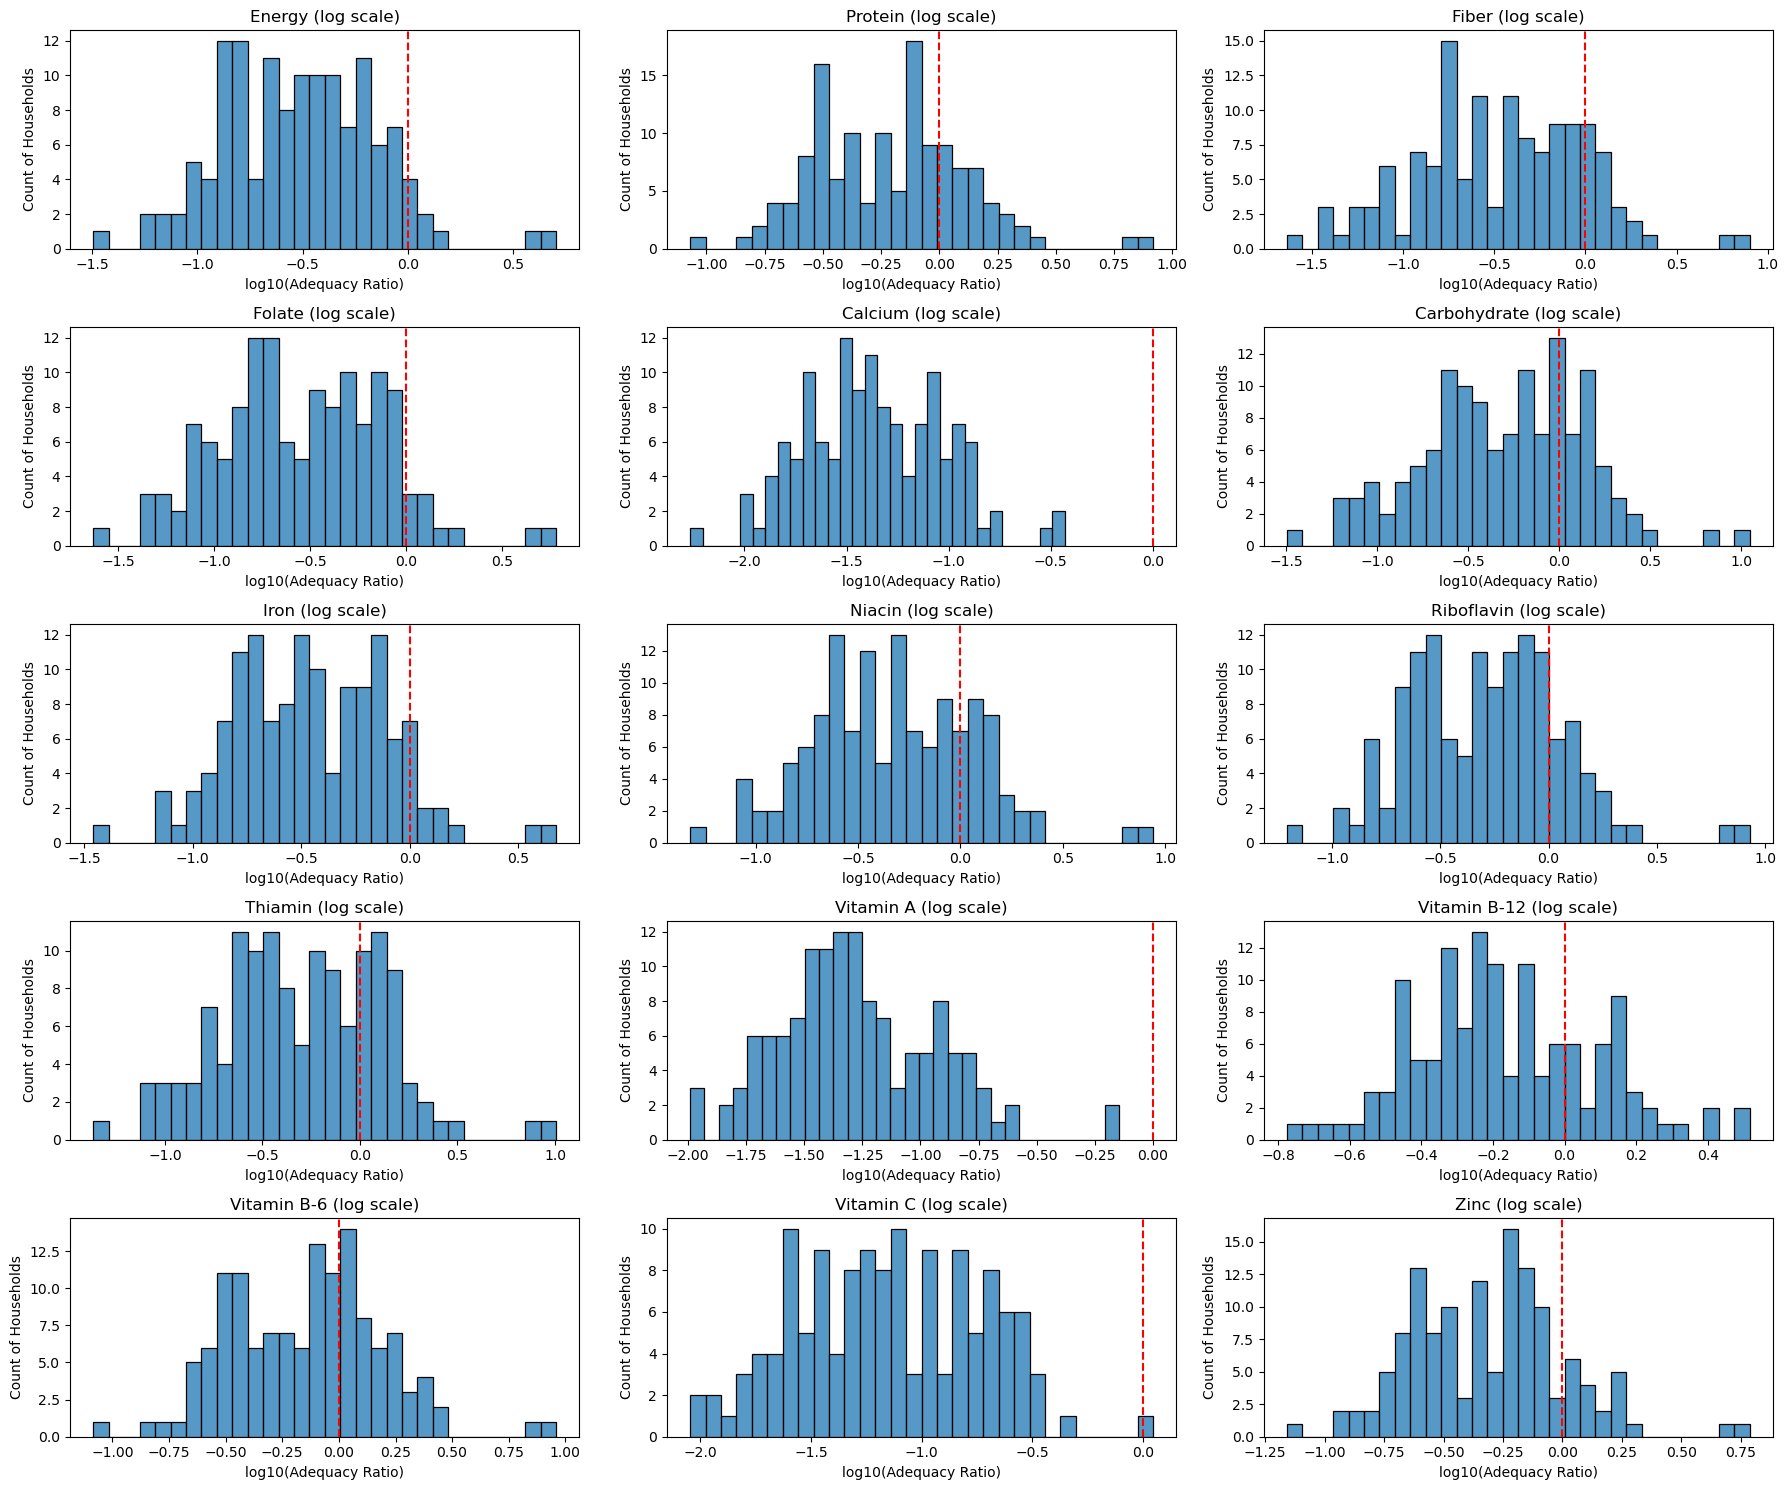

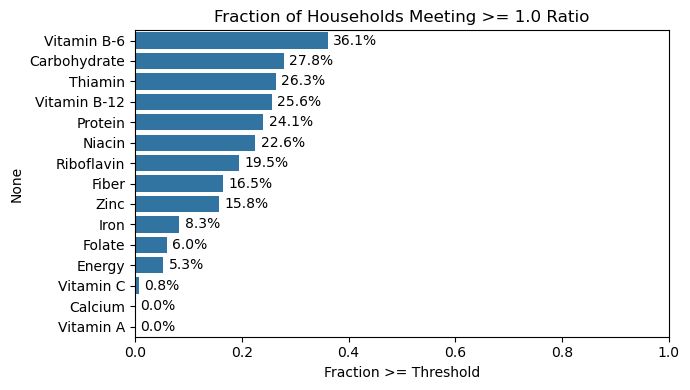

In [101]:


hhc_sub, nut_sub = filter_households(
    hhc,
    nutrient_ratio,
    min_males=0, max_males=0,       # e.g. 0 adult males
    min_females=1, max_females=1,   # e.g. 1–3 adult females
    min_kids=1, max_kids=15         # e.g. up to 2 kids
)

analyze_nutritional_adequacy_subplots_log(nut_sub)

